# Import all necessary python packages

In [70]:
# Howard Wang 05/14/19
# CSE 145: Embedded systems and design

# Main Database: https://surf.smartfin.org/

# Analyzing data from Buoy Calibration experiment to get wave direction.
# First, parse the data from the .CSV file containing ocean and wave motion data.
# This data comes from a controlled experiment (CE3), so we are assuming that 
# all of the vertical accelerations are contained in IMUA2.

# MATPLOTLIB
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

#from mpl_toolkits.basemap import Basemap

# DATAFRAMES
import pandas as pd
import numpy as np

# SCIPY
from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
import pylab as pylab

# SYSTEM and CONVERSION TOOLS
import math
import abc
import sys
import csv
import io
import os
import datetime
import pytz
import re

# MODELING AND GRAPHS
import peakutils
import statsmodels.api as sm

# URL REQUESTS
import requests

# VECTORS AND GRAPHICS
import mpld3
import folium
# import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

# PLOTTING TOOLS
from plotly import tools 
import plotly.offline
import plotly.graph_objs as go

%matplotlib notebook
%matplotlib inline

print("Done!")

Done!


In [71]:
## Read from CSV
#Full csv:
#scripps_final_combined = pd.read_csv('Scripps_Final_Combined.csv')
#print(scripps_final_combined.head())

#Gets following columns: UTC, Time, IMU A1, IMU A2, IMU A3, IMU G1, IMU G2, IMU G3, IMU M1, IMU M2, Date
motion_df = pd.read_csv('Scripps_Final_Combined.csv', usecols = [i for i in range(2, 13)])
#motion_df = motion_df.drop(['Time'], axis=1)
print(motion_df.head())
print(len(motion_df))

                              UTC   Time    IMU A1     IMU A2    IMU A3  \
0  2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1  2017-09-09T18:02:11.4800+00:00  18:02 -0.325611  11.185710 -0.459687   
2  2017-09-09T18:02:11.7310+00:00  18:02  0.000000  10.419566  1.800440   
3  2017-09-09T18:02:11.9810+00:00  18:02  0.823605  10.860099 -0.114922   
4  2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   

      IMU G1     IMU G2     IMU G3  IMU M1  IMU M2  IMU M3  
0  46.829268  15.853659  15.487805   -37.0  -199.0   517.0  
1   8.902439  -2.439024  12.073171   -33.0  -179.0   533.0  
2 -16.341463   1.463415  14.268293   -46.0  -188.0   528.0  
3  -5.731707  17.439024  21.707317   -64.0  -186.0   522.0  
4 -28.658537   1.219512  21.341463   -91.0  -175.0   493.0  
1538168


# Target a specific ride (14888)

# Scrape motion and ocean csv data from smartfin database

# Print out both dataframes

## Make copy of motion data

In [72]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

                                    UTC   Time    IMU A1     IMU A2    IMU A3  \
0        2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1        2017-09-09T18:02:11.4800+00:00  18:02 -0.325611  11.185710 -0.459687   
2        2017-09-09T18:02:11.7310+00:00  18:02  0.000000  10.419566  1.800440   
3        2017-09-09T18:02:11.9810+00:00  18:02  0.823605  10.860099 -0.114922   
4        2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   
...                                 ...    ...       ...        ...       ...   
1538163  2019-01-04T20:16:02.7080+00:00  20:16  8.216900   5.152322  0.536301   
1538164  2019-01-04T20:16:02.9080+00:00  20:16  8.178593   5.133168  0.517148   
1538165  2019-01-04T20:16:03.1010+00:00  20:16  8.159439   5.171476  0.517148   
1538166  2019-01-04T20:16:03.3020+00:00  20:16  8.159439   5.152322  0.536301   
1538167  2019-01-04T20:16:03.5040+00:00  20:16  8.140286   5.171476  0.517148   

            IMU G1     IMU 

# Drop NAs from dataset (excluding Lat and Long)

In [73]:
#Drop the "nan" values from the columns that we care about. 
#dropped_motion_df = motion_df
print(dropped_motion_df)

                                    UTC   Time    IMU A1     IMU A2    IMU A3  \
0        2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1        2017-09-09T18:02:11.4800+00:00  18:02 -0.325611  11.185710 -0.459687   
2        2017-09-09T18:02:11.7310+00:00  18:02  0.000000  10.419566  1.800440   
3        2017-09-09T18:02:11.9810+00:00  18:02  0.823605  10.860099 -0.114922   
4        2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   
...                                 ...    ...       ...        ...       ...   
1538163  2019-01-04T20:16:02.7080+00:00  20:16  8.216900   5.152322  0.536301   
1538164  2019-01-04T20:16:02.9080+00:00  20:16  8.178593   5.133168  0.517148   
1538165  2019-01-04T20:16:03.1010+00:00  20:16  8.159439   5.171476  0.517148   
1538166  2019-01-04T20:16:03.3020+00:00  20:16  8.159439   5.152322  0.536301   
1538167  2019-01-04T20:16:03.5040+00:00  20:16  8.140286   5.171476  0.517148   

            IMU G1     IMU 

In [74]:
#Reading data from Scripps_Final_Combined.csv
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Analyze following time period:
#September 9, 2017 -- 18:10 until 18:40

time_e_array = []

time_array = motion_df[['Time']].to_numpy()

#Convert time strings into seconds
start_index = np.where(time_array=='18:10')[0][0]
end_index = np.where(time_array=='18:40')[0][0]
length = end_index-start_index

mins_per_measure = 30/length
sec_per_measure = 60*mins_per_measure

print(sec_per_measure)

#start_time = 18*3600 + 10*60

for i in range(0, length):
    time_e_array.append(sec_per_measure*i)
    
imu_array1 = motion_df.loc[start_index:end_index-1,'IMU A1'].to_numpy()
imu_array2 = motion_df.loc[start_index:end_index-1,'IMU A2'].to_numpy()
imu_array3 = motion_df.loc[start_index:end_index-1,'IMU A3'].to_numpy()
imu_array4 = motion_df.loc[start_index:end_index-1,'IMU M1'].to_numpy()
imu_array5 = motion_df.loc[start_index:end_index-1,'IMU M2'].to_numpy()
imu_array6 = motion_df.loc[start_index:end_index-1,'IMU M3'].to_numpy()

0.21134202183867556


In [75]:
#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 
                                            'IMU M2', 'IMU M3'])
print(dropped_motion_df)

                                    UTC   Time    IMU A1     IMU A2    IMU A3  \
0        2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1        2017-09-09T18:02:11.4800+00:00  18:02 -0.325611  11.185710 -0.459687   
2        2017-09-09T18:02:11.7310+00:00  18:02  0.000000  10.419566  1.800440   
3        2017-09-09T18:02:11.9810+00:00  18:02  0.823605  10.860099 -0.114922   
4        2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   
...                                 ...    ...       ...        ...       ...   
1538163  2019-01-04T20:16:02.7080+00:00  20:16  8.216900   5.152322  0.536301   
1538164  2019-01-04T20:16:02.9080+00:00  20:16  8.178593   5.133168  0.517148   
1538165  2019-01-04T20:16:03.1010+00:00  20:16  8.159439   5.171476  0.517148   
1538166  2019-01-04T20:16:03.3020+00:00  20:16  8.159439   5.152322  0.536301   
1538167  2019-01-04T20:16:03.5040+00:00  20:16  8.140286   5.171476  0.517148   

            IMU G1     IMU 

# Calculate time offsets, and normalize columns

# Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

In [76]:
#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = 9.80665

# Correct the IMU Acceleration columns into units of meters
def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity + gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array3) #new units in m/s^2

# To check:
#for x,y in zip(imu2_array, imu_array_A2):
#   print(x,y)
print(len(time_e_array))

# To check:
for t in time_e_array:
    print(t)
print("Done!")

8517
0.0
0.21134202183867556
0.42268404367735113
0.6340260655160267
0.8453680873547023
1.0567101091933777
1.2680521310320534
1.479394152870729
1.6907361747094045
1.90207819654808
2.1134202183867554
2.3247622402254313
2.5361042620641068
2.7474462839027822
2.958788305741458
3.1701303275801336
3.381472349418809
3.5928143712574845
3.80415639309616
4.015498414934836
4.226840436773511
4.438182458612187
4.649524480450863
4.860866502289538
5.0722085241282135
5.2835505459668894
5.4948925678055645
5.70623458964424
5.917576611482916
6.128918633321591
6.340260655160267
6.551602676998942
6.762944698837618
6.974286720676294
7.185628742514969
7.396970764353645
7.60831278619232
7.819654808030996
8.030996829869672
8.242338851708347
8.453680873547022
8.665022895385698
8.876364917224373
9.087706939063048
9.299048960901725
9.5103909827404
9.721733004579075
9.933075026417752
10.144417048256427
10.355759070095102
10.567101091933779
10.778443113772454
10.989785135611129
11.201127157449806
11.41246917928848
1

390.7713983797111
390.9827404015498
391.19408242338847
391.40542444522714
391.6167664670658
391.8281084889045
392.03945051074317
392.25079253258184
392.4621345544205
392.6734765762592
392.88481859809787
393.09616061993654
393.3075026417752
393.5188446636139
393.73018668545257
393.94152870729124
394.1528707291299
394.3642127509686
394.57555477280727
394.78689679464594
394.9982388164846
395.2095808383233
395.42092286016197
395.63226488200064
395.8436069038393
396.054948925678
396.26629094751667
396.47763296935534
396.688974991194
396.9003170130327
397.11165903487137
397.32300105671004
397.5343430785487
397.7456851003874
397.95702712222607
398.16836914406474
398.3797111659034
398.5910531877421
398.80239520958077
399.01373723141944
399.2250792532581
399.4364212750968
399.64776329693547
399.85910531877414
400.0704473406128
400.2817893624515
400.4931313842902
400.7044734061289
400.9158154279676
401.12715744980625
401.3384994716449
401.5498414934836
401.7611835153223
401.97252553716095
402.18

707.5730891158858
707.7844311377245
707.9957731595631
708.2071151814018
708.4184572032405
708.6297992250792
708.8411412469178
709.0524832687565
709.2638252905952
709.4751673124339
709.6865093342725
709.8978513561112
710.1091933779499
710.3205353997886
710.5318774216272
710.7432194434659
710.9545614653046
711.1659034871433
711.3772455089819
711.5885875308206
711.7999295526593
712.011271574498
712.2226135963366
712.4339556181753
712.645297640014
712.8566396618527
713.0679816836913
713.27932370553
713.4906657273687
713.7020077492074
713.913349771046
714.1246917928847
714.3360338147235
714.5473758365621
714.7587178584008
714.9700598802394
715.1814019020782
715.3927439239168
715.6040859457555
715.8154279675941
716.0267699894329
716.2381120112715
716.4494540331102
716.6607960549488
716.8721380767876
717.0834800986262
717.2948221204649
717.5061641423035
717.7175061641423
717.9288481859809
718.1401902078196
718.3515322296582
718.562874251497
718.7742162733356
718.9855582951743
719.196900317012

1130.257132793237
1130.4684748150755
1130.6798168369144
1130.891158858753
1131.1025008805916
1131.3138429024302
1131.525184924269
1131.7365269461077
1131.9478689679463
1132.159210989785
1132.3705530116238
1132.5818950334624
1132.793237055301
1133.0045790771396
1133.2159210989785
1133.427263120817
1133.6386051426557
1133.8499471644943
1134.0612891863332
1134.2726312081718
1134.4839732300104
1134.695315251849
1134.9066572736879
1135.1179992955265
1135.329341317365
1135.5406833392037
1135.7520253610426
1135.9633673828812
1136.1747094047198
1136.3860514265584
1136.5973934483973
1136.808735470236
1137.0200774920745
1137.2314195139131
1137.442761535752
1137.6541035575906
1137.8654455794292
1138.0767876012678
1138.2881296231067
1138.4994716449453
1138.710813666784
1138.9221556886225
1139.1334977104614
1139.3448397323
1139.5561817541386
1139.7675237759772
1139.978865797816
1140.1902078196547
1140.4015498414933
1140.612891863332
1140.8242338851708
1141.0355759070094
1141.246917928848
1141.45825

1552.7298344487494
1552.941176470588
1553.1525184924267
1553.3638605142653
1553.5752025361041
1553.7865445579428
1553.9978865797814
1554.20922860162
1554.4205706234588
1554.6319126452975
1554.843254667136
1555.0545966889747
1555.2659387108135
1555.4772807326522
1555.6886227544908
1555.8999647763294
1556.1113067981682
1556.3226488200069
1556.5339908418455
1556.745332863684
1556.956674885523
1557.1680169073616
1557.3793589292002
1557.5907009510388
1557.8020429728776
1558.0133849947163
1558.2247270165549
1558.4360690383937
1558.6474110602323
1558.858753082071
1559.0700951039096
1559.2814371257484
1559.492779147587
1559.7041211694257
1559.9154631912643
1560.1268052131031
1560.3381472349417
1560.5494892567804
1560.760831278619
1560.9721733004578
1561.1835153222964
1561.394857344135
1561.6061993659737
1561.8175413878125
1562.0288834096511
1562.2402254314898
1562.4515674533284
1562.6629094751672
1562.8742514970058
1563.0855935188445
1563.296935540683
1563.508277562522
1563.7196195843605
1563.

# Calculate and plot magnitude of acceleration on X-Z plane

Graph of XZ Acceleration vs. Time


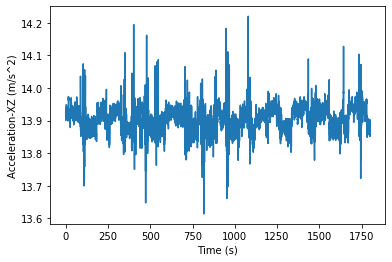

In [77]:
# Square x and z acceleration values
accel_xz_array = [];
for i in range(0, len(imu1_array)): 
    currMagnitude = math.sqrt((math.pow(imu1_array[i], 2) + math.pow(imu3_array[i], 2)))
    accel_xz_array.append(currMagnitude)

print("Graph of XZ Acceleration vs. Time")

plt.plot(time_e_array, accel_xz_array)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration-XZ (m/s^2)")
plt.show()

# Center and Calibrate Magnetometer Data

In [78]:
# Offset variables help in recentering the magnetic data in order to define direction and use trig functions
M1_offset_var = 219.786
M2_offset_var = 180
M3_offset_var = 280

def calibrate_magn_data(magn_array, offset_value):
    ret_array = []
    for m in magn_array:
        new_m = m - offset_value
        ret_array.append(new_m)
    return ret_array

imuM1_array = calibrate_magn_data(imu_array4, M1_offset_var)
imuM2_array = calibrate_magn_data(imu_array5, M2_offset_var)
imuM3_array = calibrate_magn_data(imu_array6, M3_offset_var)

# Check 
# print(imuM1_array)
print("Done.")

Done.


# Set up 3xN arrays for Magnetometer and Accel values 

In [79]:
# Create N x 3 arrays for functions that need them later on, such as Scikit Kinematics
magn_height = len(imuM1_array)
acc_height = len(imu1_array)

acc_array = np.zeros(shape=(acc_height,3))
magn_array = np.zeros(shape=(magn_height,3))

print("For Accelerometer: ")
for x in range(len(acc_array)):
    acc_array[x,0] = imu1_array[x]
    acc_array[x,1] = imu2_array[x]
    acc_array[x,2] = imu3_array[x]
print(acc_array)

print("\nFor Magnetometer: ")
for x in range(len(magn_array)):
    magn_array[x,0] = imuM1_array[x]
    magn_array[x,1] = imuM2_array[x]
    magn_array[x,2] = imuM3_array[x]

print(magn_array)
print("Done.")

For Accelerometer: 
[[9.86571461 9.97173741 9.82389246]
 [9.86608147 9.96476705 9.81655524]
 [9.86975008 9.9699031  9.81141919]
 ...
 [9.80298139 9.98274323 9.81582152]
 [9.80114709 9.99448278 9.80958489]
 [9.80188081 9.99228162 9.78757323]]

For Magnetometer: 
[[-371.786 -310.     256.   ]
 [-352.786 -317.     255.   ]
 [-347.786 -326.     244.   ]
 ...
 [-156.786 -349.     269.   ]
 [-159.786 -360.     264.   ]
 [-161.786 -368.     256.   ]]
Done.


# Conversion from fin-frame to board-frame

Orientation from here onwards will be from the board/surfers reference frame (yaw left = turning left)

x = -IMU1, y = -IMU3, z = -IMU2

In [80]:
# The new array for board reference frame will have the IMUs in columns according to X,Y,Z directions
board_acc = acc_array.copy()       # Reassign to the correct axes as stated above
temp_x_acc = board_acc[:,0] * (-1)
temp_y_acc = board_acc[:,1] * (-1)
temp_z_acc = board_acc[:,2] * (-1)
board_acc[:,0] = temp_x_acc     # X acceleration
board_acc[:,1] = temp_y_acc     # Y acceleration
board_acc[:,2] = temp_z_acc     # Z acceleration
print(board_acc)
print("\n")

board_magn = magn_array.copy()
temp_x_magn = board_magn[:,0] * (-1)
temp_y_magn = board_magn[:,1] * (-1)
temp_z_magn = board_magn[:,2] * (-1)
board_magn[:,0] = temp_x_magn
board_magn[:,1] = temp_y_magn
board_magn[:,2] = temp_z_magn
print(board_magn)
print("Done.")

[[-9.86571461 -9.97173741 -9.82389246]
 [-9.86608147 -9.96476705 -9.81655524]
 [-9.86975008 -9.9699031  -9.81141919]
 ...
 [-9.80298139 -9.98274323 -9.81582152]
 [-9.80114709 -9.99448278 -9.80958489]
 [-9.80188081 -9.99228162 -9.78757323]]


[[ 371.786  310.    -256.   ]
 [ 352.786  317.    -255.   ]
 [ 347.786  326.    -244.   ]
 ...
 [ 156.786  349.    -269.   ]
 [ 159.786  360.    -264.   ]
 [ 161.786  368.    -256.   ]]
Done.


# Calculate magnitude of XYZ acceleration vs time

8517
Graph of XYZ Acceleration vs. Time


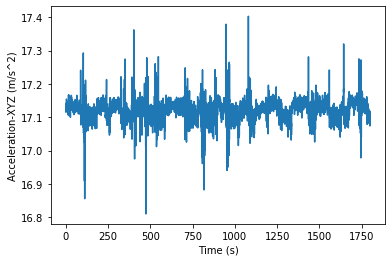

In [81]:
# Square x, y and z acceleration values
accel_xyz_array = [];
for i in range(0, len(board_acc)): 
    currMagnitude = math.sqrt(math.pow(board_acc[i][0], 2) + math.pow(board_acc[i][1], 2) + math.pow(board_acc[i][2], 2))
    accel_xyz_array.append(currMagnitude)

# Check length
print(len(accel_xyz_array))
print("Graph of XYZ Acceleration vs. Time")

plt.plot(time_e_array, accel_xyz_array)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration-XYZ (m/s^2)")
plt.show()

# Azimuth and altitude calculations

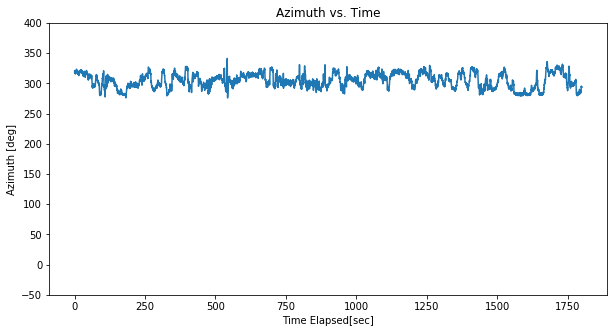

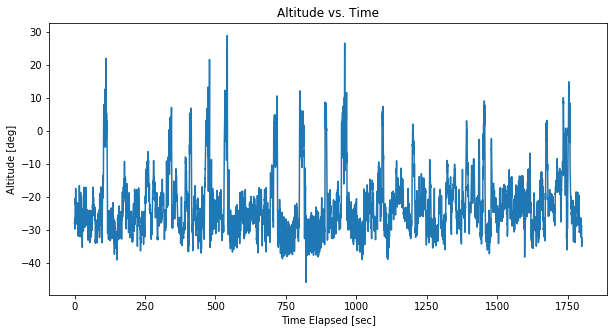

In [82]:
# Azimuth and Altitude LEGEND:
# Altitude is the angle between the ground and the vector 
# Azimuth is the angle going clockwise from 0 deg North:
# N - 0/360deg, E - 90deg, S - 180deg, W - 270deg

# This will get complicated (ie make cases or lots of if statements) when rotations about the heading become more prevalent
def azimuth(x,y,z):
    real_y = y * (-1) # This is to account for y 
    return (180/math.pi * math.atan2(real_y,x)) % 360

def altitude(x,y,z):
    h = math.hypot(y, x)
    return 180/math.pi * math.atan2(z,h)

def printAltAzi(alt, azi):
    print ("Alt:", alt, "\n", "Azi:",azi,"\n")
# These values are uncorrected values: still need to add or subtract 'declination'
#     (for AziMuth) and 'inclination' (for Altitude) correction values for geographical location

heading_altitude = board_magn[:,0].copy()
heading_azimuth = board_magn[:,0].copy()

i = 0     #iterator
#for i in range(len(M1_no_out)):
while i < len(heading_altitude):
    heading_altitude[i] = altitude(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    heading_azimuth[i] = azimuth(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    #printAltAzi(heading_altitude[i],heading_azimuth[i])
    i += 1

heading_azi_plot = plt.figure(figsize=(10,5))
azi_plot = heading_azi_plot.add_subplot(111)
azi_plot.plot(time_e_array, heading_azimuth)
azi_plot.set_title("Azimuth vs. Time")
azi_plot.set_xlabel("Time Elapsed[sec]")
azi_plot.set_ylabel("Azimuth [deg]")
azi_plot.set_ylim([-50,400])

heading_alt_plot = plt.figure(figsize=(10,5))
alt_plot = heading_alt_plot.add_subplot(111)
alt_plot.plot(time_e_array, heading_altitude)
alt_plot.set_title("Altitude vs. Time")
alt_plot.set_xlabel("Time Elapsed [sec]")
alt_plot.set_ylabel("Altitude [deg]")
plt.show()

#for t in range(len(time_e_array)):
    #printAltAzi(heading_altitude[t], heading_azimuth[t])

# Plot polar azimuth and altitude

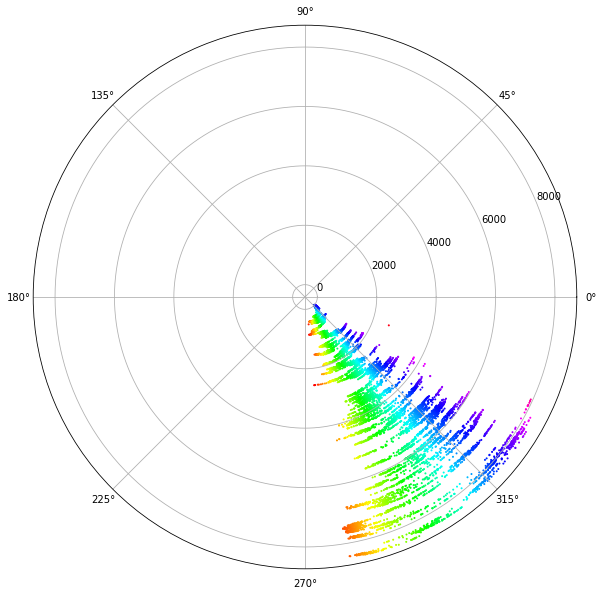

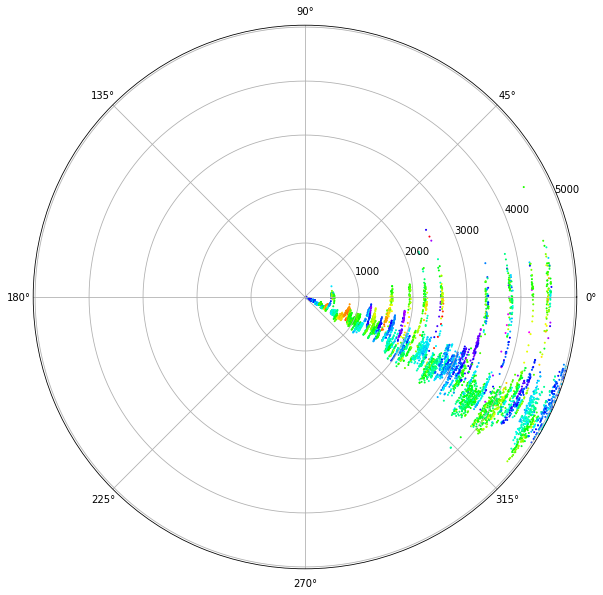

In [83]:
# Fixing random state for reproducibility
np.random.seed(19680801)

# Compute areas and colors
r = [i for i in range(0, len(board_magn))]
theta = heading_azimuth/360 * 2 * np.pi
area = 1
colors = theta

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=1)

# Compute areas and colors
alt_r = [i for i in range(0, len(board_magn))]
alt_theta = heading_altitude/360 * 2 * np.pi
alt_area = 1
alt_colors = theta

fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(111, projection='polar')
c2 = ax2.scatter(alt_theta, alt_r, c=alt_colors, s=alt_area, cmap='hsv', alpha=1)

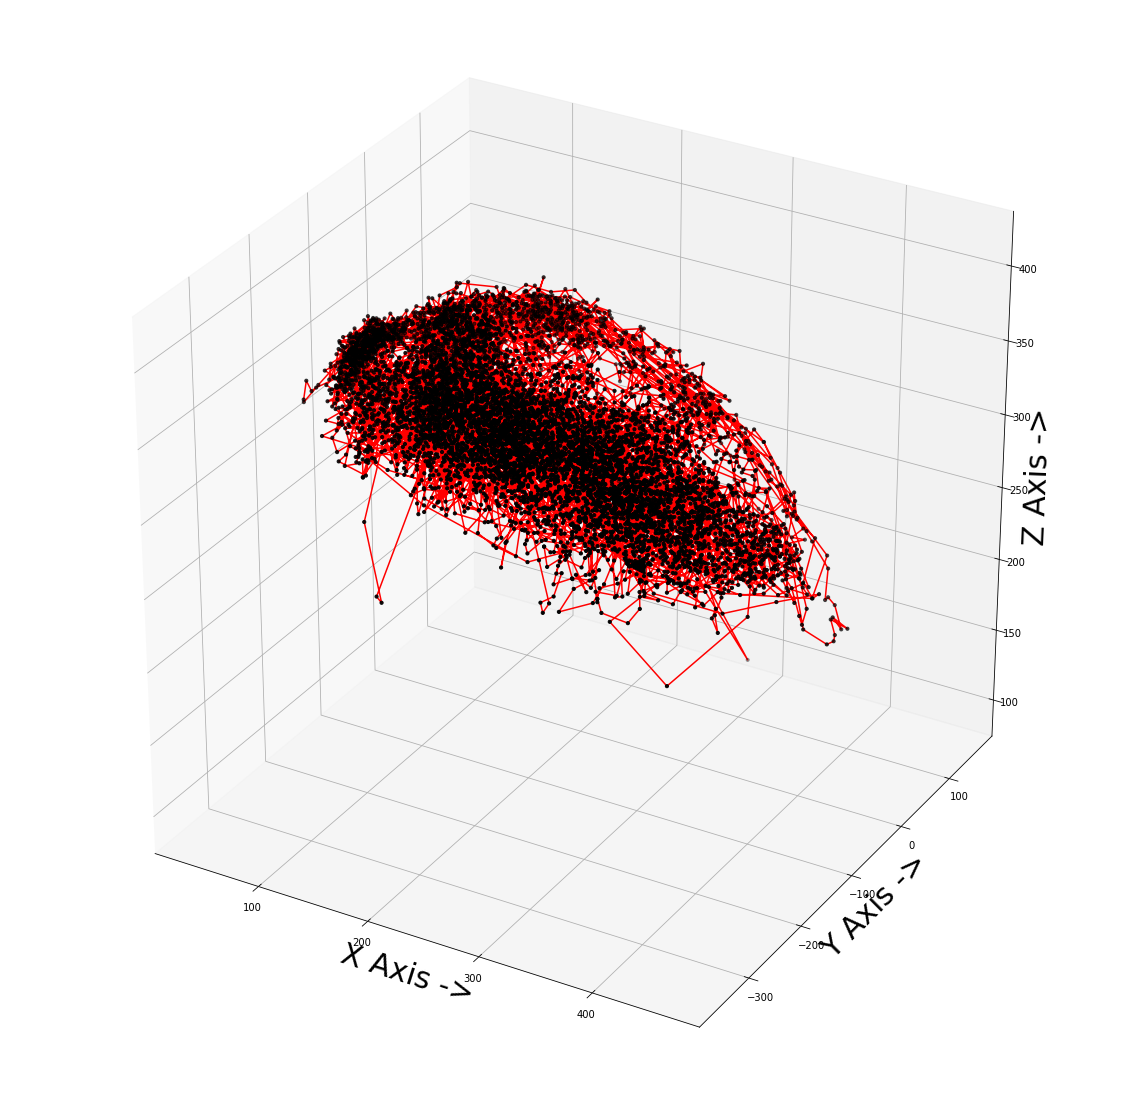

In [84]:
# Plot first 10 directional changes 
magnfig = plt.figure(figsize=(20,20))
magnaxi = magnfig.add_subplot(111, projection='3d')
magnaxi.scatter(board_magn[0,0], board_magn[0,2], board_magn[0,1], c='black', s=300, marker = "<")
magnaxi.scatter(board_magn[1:,0], board_magn[1:,2], board_magn[1:,1], c='black', s=10, marker = "o")
magnaxi.plot(board_magn[:,0], board_magn[:,2], board_magn[:,1], color='red')
magnaxi.set_xlabel("X Axis ->", fontsize=30)
magnaxi.set_ylabel("Y Axis ->", fontsize=30)
magnaxi.set_zlabel("Z Axis ->", fontsize=30)
plt.show()

In [87]:
## Read from CSV
#Full csv:
#scripps_final_combined = pd.read_csv('Scripps_Final_Combined.csv')
#print(scripps_final_combined.head())

#Gets following columns: UTC, Time, IMU A1, IMU A2, IMU A3, IMU G1, IMU G2, IMU G3, IMU M1, IMU M2, Date
motion_df = pd.read_csv('Scripps_Final_Combined.csv', usecols = [i for i in range(2, 13)])
#motion_df = motion_df.drop(['Time'], axis=1)
print(motion_df.head())
print(len(motion_df))

   Unnamed: 0                                                 ID  \
0           0  google_106807627751629413403_0006667E228C_1709...   
1           1  google_106807627751629413403_0006667E228C_1709...   
2           2  google_106807627751629413403_0006667E228C_1709...   
3           3  google_106807627751629413403_0006667E228C_1709...   
4           4  google_106807627751629413403_0006667E228C_1709...   

                              UTC   Time    IMU A1     IMU A2    IMU A3  \
0  2017-09-09T18:02:11.2810+00:00  18:02  0.000000  11.070788  0.134075   
1  2017-09-09T18:02:11.4800+00:00  18:02 -0.325611  11.185710 -0.459687   
2  2017-09-09T18:02:11.7310+00:00  18:02  0.000000  10.419566  1.800440   
3  2017-09-09T18:02:11.9810+00:00  18:02  0.823605  10.860099 -0.114922   
4  2017-09-09T18:02:12.1800+00:00  18:02  0.670376  11.492168 -0.651223   

      IMU G1     IMU G2     IMU G3  IMU M1  IMU M2  IMU M3        Date  \
0  46.829268  15.853659  15.487805   -37.0  -199.0   517.0  2017-0

In [86]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data included

#print(saved_copy_motion_df)